In [1]:
# 📘 Notebook: UMAP/t-SNE Visualization for DANN-only Model (Phase 3)

# 📌 Cell 1: Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import seaborn as sns
from tqdm import tqdm



2025-03-24 19:53:22.794137: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 19:53:22.845037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742826202.873524   15237 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742826202.881391   15237 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 19:53:22.943249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# 📌 Cell 2: Paths
model_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/Models/DANN/dann_model.keras"
tfrecord_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/Dataset/PlantVillage_Structured/AUG_TFRecord/split"
test_tfrecord = os.path.join(tfrecord_path, "test.tfrecord")


In [3]:

# 📌 Cell 3: Constants
NUM_CROPS = 9
NUM_DISEASES = 38
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE



In [4]:
# 📌 Cell 4: Parse TFRecord Function
feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "crop": tf.io.FixedLenFeature([], tf.int64),
    "disease": tf.io.FixedLenFeature([], tf.int64)
}

def parse_example(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    crop_label = parsed['crop']
    disease_label = parsed['disease']
    return image, (crop_label, disease_label)



In [5]:
# 📌 Cell 5: Load Dataset

def load_dataset(path):
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(parse_example, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

test_dataset = load_dataset(test_tfrecord)



I0000 00:00:1742826215.154560   15237 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2051 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
# 📌 Cell 6: Load DANN Model
model = tf.keras.models.load_model(model_path, compile=False)



In [7]:
# 📌 Cell 7: Extract Features from Feature Extractor Layer
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=-4).output)

features = []
crop_labels = []
disease_labels = []

for batch in tqdm(test_dataset):
    images, (crops, diseases) = batch
    feats = feature_extractor(images)
    features.append(feats.numpy())
    crop_labels.extend(crops.numpy())
    disease_labels.extend(diseases.numpy())

features = np.concatenate(features, axis=0)
crop_labels = np.array(crop_labels)
disease_labels = np.array(disease_labels)



2025-03-24 19:53:41.765034: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
I0000 00:00:1742826222.844239   15237 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-24 19:54:16.365510: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
142it [00:34,  4.10it/s]


In [8]:
# 📌 Cell 8: UMAP Projection
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
umap_proj = umap_model.fit_transform(features)



/home/srivatsa/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [9]:
# 📌 Cell 9: t-SNE Projection
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_proj = tsne_model.fit_transform(features)



In [10]:
# 📌 Cell 10: Save Plots Directory
plot_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/reports/DANN_Model/Plots"
os.makedirs(plot_path, exist_ok=True)



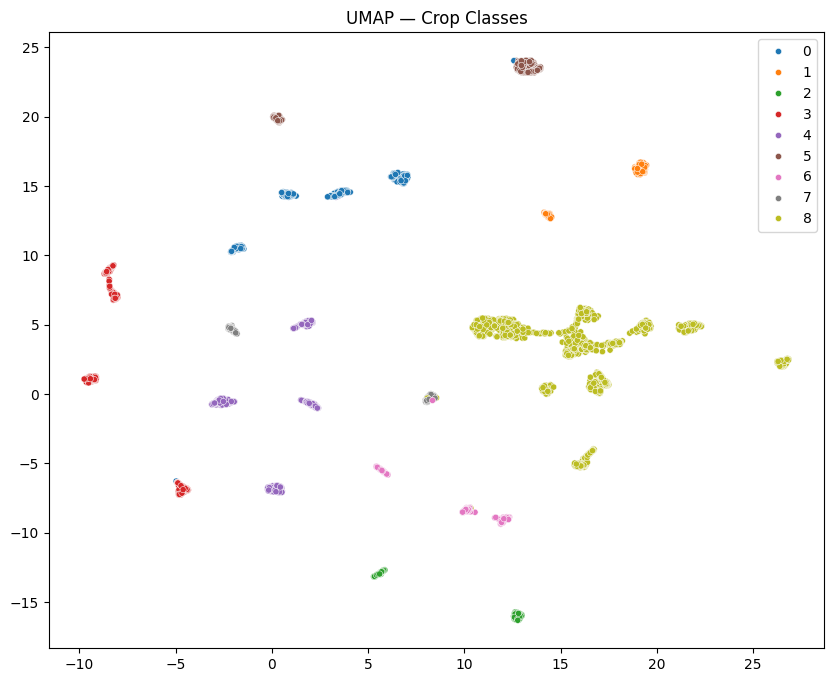

In [11]:
# 📌 Cell 11: Plot UMAP — Crop Labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_proj[:, 0], y=umap_proj[:, 1], hue=crop_labels, palette="tab10", s=20)
plt.title("UMAP — Crop Classes")
plt.savefig(os.path.join(plot_path, "UMAP_Crop_Classes.png"))
plt.show()



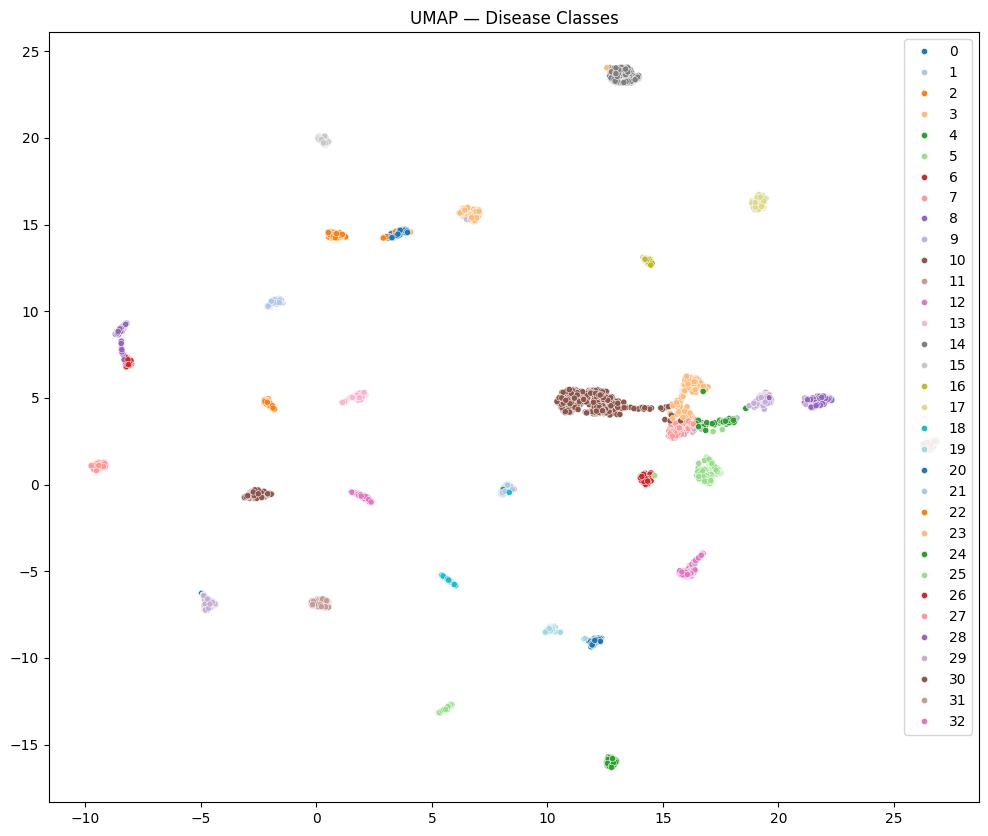

In [12]:
# 📌 Cell 12: Plot UMAP — Disease Labels
plt.figure(figsize=(12, 10))
sns.scatterplot(x=umap_proj[:, 0], y=umap_proj[:, 1], hue=disease_labels, palette="tab20", s=20)
plt.title("UMAP — Disease Classes")
plt.savefig(os.path.join(plot_path, "UMAP_Disease_Classes.png"))
plt.show()



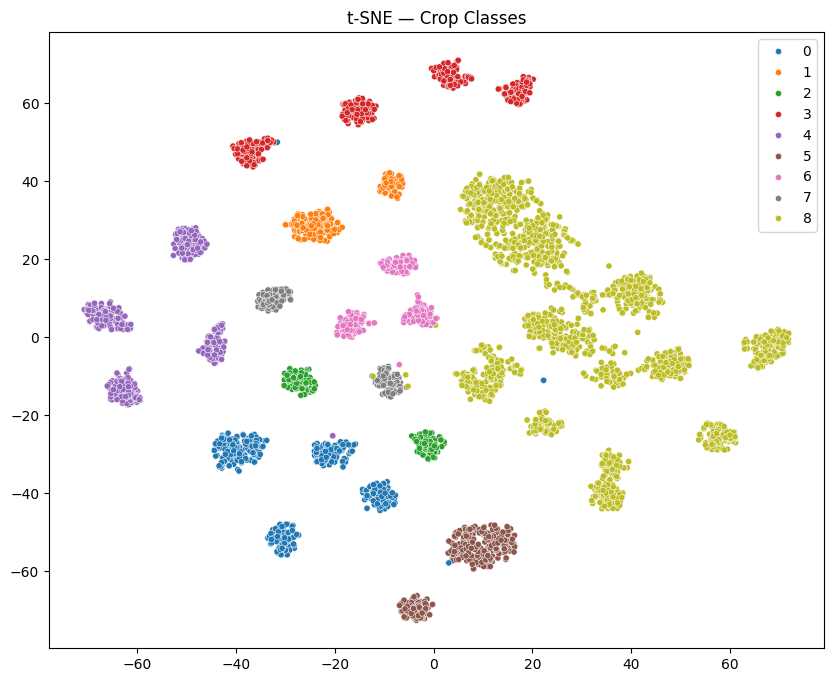

In [13]:
# 📌 Cell 13: Plot t-SNE — Crop Labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=crop_labels, palette="tab10", s=20)
plt.title("t-SNE — Crop Classes")
plt.savefig(os.path.join(plot_path, "TSNE_Crop_Classes.png"))
plt.show()



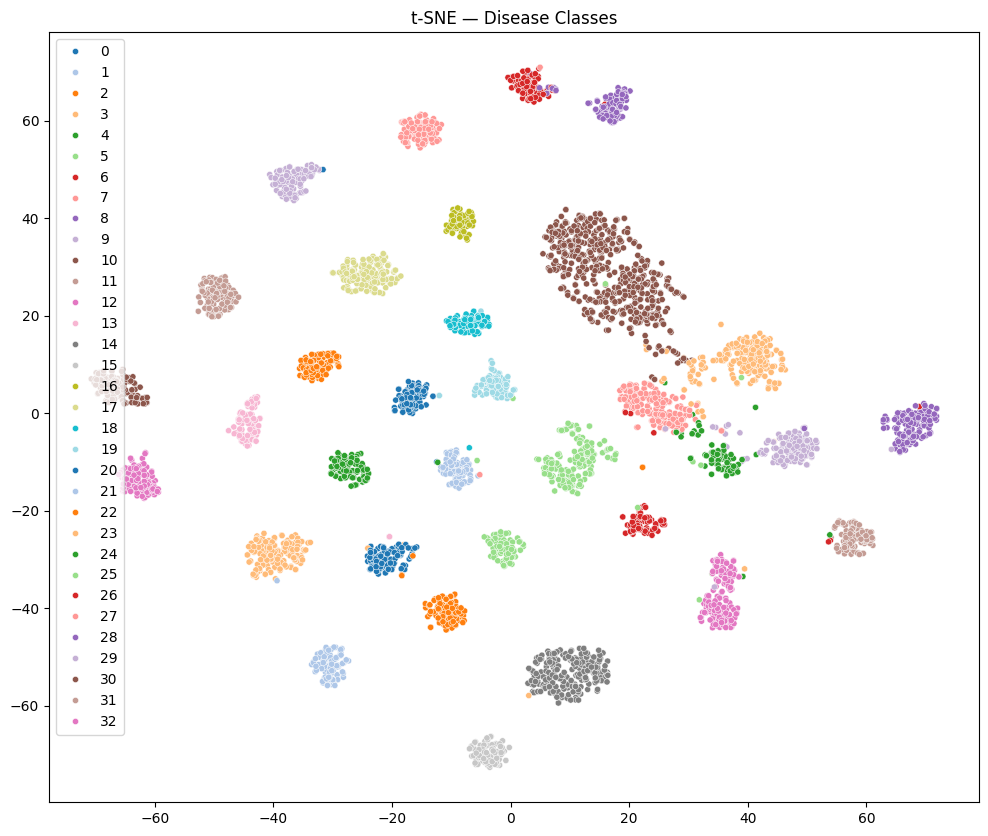

In [14]:
# 📌 Cell 14: Plot t-SNE — Disease Labels
plt.figure(figsize=(12, 10))
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=disease_labels, palette="tab20", s=20)
plt.title("t-SNE — Disease Classes")
plt.savefig(os.path.join(plot_path, "TSNE_Disease_Classes.png"))
plt.show()


In [15]:
# 📌 Cell 15: Save Class Mappings as Text File
class_map_path = os.path.join(plot_path, "class_mapping.txt")
with open(class_map_path, "w") as f:
    f.write("CROP LABELS:\n")
    for i in range(NUM_CROPS):
        f.write(f"Crop {i}\n")
    f.write("\nDISEASE LABELS:\n")
    for i in range(NUM_DISEASES):
        f.write(f"Disease {i}\n")

print("✅ UMAP & t-SNE plots saved. Class mapping file created.")


✅ UMAP & t-SNE plots saved. Class mapping file created.
